# Imports + Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json

from qiskit import *
from qiskit_ibm_provider import IBMProvider
import mthree
from qiskit_ibm_runtime import QiskitRuntimeService, Session, SamplerV1, Options

In [2]:
token = '' # Put in your IBM token
QiskitRuntimeService.save_account(channel="ibm_quantum", token=token, overwrite= True)

# Functions to Write the VQE circuits

In [3]:
def apply_Utheta(qc, qubit, theta):
    """
    Applies U(theta) = cos(theta)|0><0| + sin(theta)|0><1| - sin(theta)|1><0| + cos(theta)|1><1| to specified qubit in quantum circuit
    Inputs: qc - quantum circuit
            qubit - qubit in quantum circuit to apply U(theta) to
            theta - variational parameter
    Outputs: None
    """
    U = np.array([[np.cos(theta), np.sin(theta)], [-np.sin(theta), np.cos(theta)]])
    gate_label = "Utheta"
    qc.unitary(U, [qubit], label = gate_label)

In [4]:
def twirled_cz(qc, qubit1, qubit2, repeats=1):
    """
    twirl is an integer in {0, 1, ... 15}, representing one of possible 16 Pauli twirls of {I, X, Y, Z}^{otimes 2} in 4-ary.
    repeats is some (odd) number for which the CZ is repeated (1 by default)
    """
    for _ in range(repeats):
        twirl = np.random.randint(16)
        match twirl:
            case 0: # II
                qc.cz(qubit1, qubit2)

            case 1:
                qc.x(qubit2)
                qc.cz(qubit1, qubit2)
                qc.z(qubit1)
                qc.x(qubit2)
            
            case 2:
                qc.z(qubit2)
                qc.cz(qubit1, qubit2)
                qc.z(qubit2)

            case 3:
                qc.y(qubit2)
                qc.cz(qubit1, qubit2)
                qc.z(qubit1)
                qc.y(qubit2)

            case 4:
                qc.x(qubit1)
                qc.cz(qubit1, qubit2)
                qc.x(qubit1)
                qc.z(qubit2)

            case 5:
                qc.x(qubit1)
                qc.x(qubit2)
                qc.cz(qubit1, qubit2)
                qc.y(qubit1)
                qc.y(qubit2)

            case 6:
                qc.x(qubit1)
                qc.z(qubit2)
                qc.cz(qubit1, qubit2)
                qc.x(qubit1)

            case 7:
                qc.x(qubit1)
                qc.y(qubit2)
                qc.cz(qubit1, qubit2)
                qc.y(qubit1)
                qc.x(qubit2)

            case 8:
                qc.z(qubit1)
                qc.cz(qubit1, qubit2)
                qc.z(qubit1)

            case 9:
                qc.z(qubit1)
                qc.x(qubit2)
                qc.cz(qubit1, qubit2)
                qc.x(qubit2)

            case 10:
                qc.z(qubit1)
                qc.z(qubit2)
                qc.cz(qubit1, qubit2)
                qc.z(qubit1)
                qc.z(qubit2)

            case 11:
                qc.z(qubit1)
                qc.y(qubit2)
                qc.cz(qubit1, qubit2)
                qc.y(qubit2)

            case 12:
                qc.y(qubit1)
                qc.cz(qubit1, qubit2)
                qc.y(qubit1)
                qc.z(qubit2)

            case 13:
                qc.y(qubit1)
                qc.x(qubit2)
                qc.cz(qubit1, qubit2)
                qc.x(qubit1)
                qc.y(qubit2)

            case 14:
                qc.y(qubit1)
                qc.z(qubit2)
                qc.cz(qubit1, qubit2)
                qc.y(qubit1)

            case 15:
                qc.y(qubit1)
                qc.y(qubit2)
                qc.cz(qubit1, qubit2)
                qc.x(qubit1)
                qc.x(qubit2)

In [5]:
def generate_onequbit_circuit(theta, s):
    """
    Generates the VQE circuit |0>-[H^s]-[U]-||Z for <Xi> and <Ki> measurements.
    Inputs: theta - variational parameter
            s - whether H is applied (so input is |+>) or not (so input is |0>)
    Outputs: The 1-qubit VQE circuit
    """
    # Initializes circuit
    qr = QuantumRegister(1)
    qc = QuantumCircuit(qr)

    # Apply Z^s
    if s == 1:
        qc.h(0)

    # Apply U(theta) to qubit
    apply_Utheta(qc, 0, theta)

    # Measure in comp. basis
    qc.measure_all()

    return qc

def generate_twoqubit_circuit(theta, s, sprime):
    """
    Generates the two-qubit VQE circuit for measurement of <Ki>
    Inputs: theta - variational parameter
            s - coin flip for putting Z on the first qubit
            sprime - first circuit outcome dependent Z on the second qubit
    """    
    qr = QuantumRegister(2)
    qc = QuantumCircuit(qr)

    # Make cluster chain
    qc.h(qr)
    qc.twirled_cz(qc, 0, 1)

    if s == 1:
        qc.z(0)
    if sprime == 1:
        qc.z(1)

    qc.h(0)
    apply_Utheta(qc, 0, theta)
    apply_Utheta(qc, 1, theta)
    
    qc.measure_all()
    
    return qc

def generate_allonecirc(theta):
    """
    Generates all circuits necessary for one point of the VQE protocol and on one circuit
    """
    qr = QuantumRegister(11)
    qc = QuantumCircuit(qr)

    # Circuit 1 for <X>
    qc.h(0)
    apply_Utheta(qc, 0, theta)

    # Circuit 2 for <K>_boundary:
    apply_Utheta(qc, 1, theta)

    # Circuit 3 (1 qubit) for <K>_bulk:
    qc.h(2)
    apply_Utheta(qc, 2, theta)

    # Circuits 4-7 for (2 qubit) for <K>_bulk:
    qc.h([3, 4, 5, 6, 7, 8, 9, 10])
    twirled_cz(qc, 3, 4)
    twirled_cz(qc, 5, 6)
    twirled_cz(qc, 7, 8)
    twirled_cz(qc, 9, 10)
    qc.z([5, 8, 9, 10])
    qc.h([4, 6, 8, 10])
    apply_Utheta(qc, 3, theta)
    apply_Utheta(qc, 4, theta)
    apply_Utheta(qc, 5, theta)
    apply_Utheta(qc, 6, theta)
    apply_Utheta(qc, 7, theta)
    apply_Utheta(qc, 8, theta)
    apply_Utheta(qc, 9, theta)
    apply_Utheta(qc, 10, theta)

    qc.measure_all()
    return qc

In [6]:
def generate_circuits(theta_list):
    """
    Generates n circuits (one for each VQE parameter)
    Inputs: theta_list - array of VQE parameters there
    Outputs: List of len(theta_list) circuits
    """ 
    qc_list = []
    for theta in theta_list:
        qc_list.append(generate_allonecirc(theta))
    return qc_list


In [7]:
def mitigate_counts(mit, raw_counts, shots_num, best_qubits):
    mitigated_quasi_probs = mit.apply_correction(raw_counts, best_qubits)
    # mitigated_stddev = mitigated_quasi_probs._stddev_upper_bound
    mitigated_probs = (mitigated_quasi_probs.nearest_probability_distribution())
    mitigated_counts = {label: prob * shots_num for label, prob in mitigated_probs.items()}
    return mitigated_counts

# Running the VQE Circuits

The older way (when this data was taken) of submitting jobs was to submit each job individually, using the following script (first defining a backend, then sending each circuit to be run):

In [8]:
# These were the parameters used to run the circuits in the displayed data
theta_ar = np.linspace(0, np.pi/4, 250)
shots_num = 5000
best_qubits = [2, 64, 105, 12, 13, 27, 28, 40, 41, 116, 117]  # Pick less noisy qubits

In [9]:
provider = IBMProvider()
provider.backends()

[<IBMBackend('ibm_quebec')>,
 <IBMBackend('ibm_brisbane')>,
 <IBMBackend('ibm_kyoto')>,
 <IBMBackend('ibm_osaka')>,
 <IBMBackend('ibm_sherbrooke')>]

In [19]:
backend = provider.get_backend("ibm_quebec")

In [41]:
def run_circuits(qc_list, backend, best_qubits, shots_num):
    """
    Runs quantum circuit(s)
    Inputs: qc_list - List of QuantumCircuit Objects
           backend - Which backend (simulator or device) to use
           best_qubits - which qubits to use on the backend
           shots_num - how many shots per experiment
    Outputs: List containing 4 dictionaries corresponding to counts/experimental results from supplied experiments.
    """
    qc_trans = transpile(qc_list, backend=backend, initial_layout=best_qubits)
    job_exp = backend.run(qc_trans, shots=shots_num)
    print('All jobs have finished.')
    results = job_exp.result()
    counts_list = []
    for i in range(len(qc_list)):
        counts_list.append(results.get_counts(i))
    return counts_list

The more up-to-date way (that is better at getting jobs ahead of the queue) is to submit things as a session:

In [ ]:
service = QiskitRuntimeService()
backend = service.backend("ibm_quebec")

In [ ]:
with Session(service=service, backend=backend) as session:
    options = Options()
    options.resilience_level = 1  # Set level of error mitigation
    options.optimization_level = 0  # Set optimization level
    sampler = SamplerV1(session=session, options=options)  # Note that SamplerV1 is soon deprecated
    print(session.details())
    print(session.status())

    qc_list = transpile(generate_circuits(theta_list), backend=backend, initial_layout=best_qubits)
    job_exp = sampler.run(qc_list, shots=shots_num)
    print(session.status())

    # Add more jobs to the session if desired

# Post-Processing Data

In [20]:
# Note: Previously, one would run a set of mitigation circuits separately from the sampling circuits, and use the obtained mitigation matrices to mitigate the readout errors on the data. Now, the Sampler functions in Qiskit already include this readout mitigation functionality, so this extra step is no longer necessary. The VQE data was taken on an older version of Qiskit and so the post-processing of the data involves some extra steps. If re-running this experiment, it is recommended to use the new Sampler objects in Qiskit which handle the measurement error mitigation automatically.

In [4]:
# These were the parameters used to run the circuits in the displayed data
theta_ar = np.linspace(0, np.pi/4, 250)
shots_num = 5000
best_qubits = [2, 64, 105, 12, 13, 27, 28, 40, 41, 116, 117]

In [22]:
mit = mthree.M3Mitigation(backend)
# mit.cals_from_system(best_qubits) # if mitigating current state of the device
mit.cals_from_file('calibrations/VQE_cals_0326.json')

In [23]:
# 8 json files (i.e. 8 runs of the same experiment), each corresponding to a 250 VQE datapoints, of 5k shots each
job_names = ["cr1xfmyk5z70008951qg", "cr1xm9s8gdp0008g3qj0", "cr1xs4mk5z7000895520", "cr1xwn2dvs8g008jdt0g", "cr1y0yvk5z70008957y0", "cr1y6ehdvs8g008jdvz0", "cr1y9d5s9z7g008dyjjg", "cr1ycr3s9z7g008dyk80"]

In [24]:
def process_results_decomposed(counts_list):
    X_list = []
    Kboundary_list = []
    Kbulk_list = []

    i = 0
    for counts in counts_list:
        i += 1
        states = counts.keys()

        X_plus = 0
        X_minus = 0
        Kboundary_plus = 0
        Kboundary_minus = 0
        Kbulk_plus = 0
        Kbulk_minus = 0

        for state in states:
            count = counts.get(state)

            # Calculate <X>:
            s1 = int(state[-1])
            if s1 == 0:
                X_plus += count
            else:
                X_minus += count

            # Calculate <K>_boundary:
            s2 = int(state[-2])
            if s2 == 0:
                Kboundary_plus += count
            else:
                Kboundary_minus += count

            # Calculate <K>_bulk:
            s3 = int(state[-3])
            count == count / 2 # For the 50/50 "coin flip"
            if s3 == 0:
                s = int(state[-4])
                sprime = int(state[-5])
                if (s3 + s + sprime) % 2 == 0:
                    Kbulk_plus += count
                else:
                    Kbulk_minus += count
                s = int(state[-6])
                sprime = int(state[-7])
                if (s3 + s + sprime) % 2 == 0:
                    Kbulk_plus += count
                else:
                    Kbulk_minus += count
            else:
                s = int(state[-8])
                sprime = int(state[-9])
                if (s3 + s + sprime) % 2 == 0:
                    Kbulk_plus += count
                else:
                    Kbulk_minus += count
                s = int(state[-10])
                sprime = int(state[-11])
                if (s3 + s + sprime) % 2 == 0:
                    Kbulk_plus += count
                else:
                    Kbulk_minus += count

        
        Xcount = X_plus + X_minus
        Xavg = (X_plus - X_minus)/Xcount
        X_list.append(Xavg)

        Kcount = Kboundary_plus + Kboundary_minus
        Kboundaryavg = (Kboundary_plus - Kboundary_minus)/Kcount
        Kboundary_list.append(Kboundaryavg)

        Kcount = Kbulk_plus + Kbulk_minus
        Kbulkavg = (Kbulk_plus - Kbulk_minus)/Kcount
        Kbulk_list.append(Kbulkavg)

    return np.array(X_list), np.array(Kboundary_list), np.array(Kbulk_list)

In [25]:
def hex_conversion(hex_string):
    # Convert a hex string to a binary string (with 11 digits)
    bin_string = bin(int(hex_string, 0))[2:]
    length = len(bin_string)
    if length == 11:
        return bin_string
    else:
        zero_str = "0"
        return zero_str * (11 - length) + bin_string

def dict_hex_conversion(dict):
    # Convert a dictionary with hexadecimal keys into ones with binary keys
    hex_converted_dict = {}
    for key, val in dict.items():
        hex_converted_dict[hex_conversion(key)] = val
    return hex_converted_dict

def mitigate_counts_single(mit, raw_counts, shots_num, best_qubits, hex=False):
    # Use readout mitigation matrices to mitigate the raw results of an experiment.
    if hex:
        hex_converted_counts = dict_hex_conversion(raw_counts)
        mitigated_quasi_probs = mit.apply_correction(hex_converted_counts, best_qubits)
    else:
        mitigated_quasi_probs = mit.apply_correction(raw_counts, best_qubits)
    # mitigated_stddev = mitigated_quasi_probs._stddev_upper_bound
    mitigated_probs = (mitigated_quasi_probs.nearest_probability_distribution())
    mitigated_counts = {label: prob * shots_num for label, prob in mitigated_probs.items()}
    return mitigated_counts

In [26]:
# Extract result dictionaries from files

results_list_across_repeats = []
for job_name in job_names:
    file = "raw_data/VQE_" + job_name + ".json"
    f = open(file)
    job_f = json.load(f)
    results_list_across_repeats.append(job_f.get("results"))
    f.close()

In [27]:
# Extract count dictionaries from files, and mitigate readout mitigation errors

counts_list_across_repeats = []
for result in results_list_across_repeats:
    counts_list = []
    for i in range(len(theta_ar)):
        counts_list.append(mitigate_counts_single(mit, result[i].get("data").get("counts"), shots_num, best_qubits, hex=True))
    counts_list_across_repeats.append(counts_list)

In [28]:
# Compute <X>, <K>boundary, <K>bulk

X_ars = []
K_boundary_ars = []
K_bulk_ars = []
for counts_list in counts_list_across_repeats:
    X_ar, K_boundary_ar, K_bulk_ar = process_results_decomposed(counts_list)
    X_ars.append(X_ar)
    K_boundary_ars.append(K_boundary_ar)
    K_bulk_ars.append(K_bulk_ar)

In [29]:
# Compute means and standard error of means for <X>, <K>boundary, <K>bulk across trials

X_ar_mean = []
X_ar_std = []
K_boundary_ar_mean = []
K_boundary_ar_std = []
K_bulk_ar_mean = []
K_bulk_ar_std = []

for t in range(len(theta_ar)):
    X_ar = []
    K_boundary_ar = []
    K_bulk_ar = []
    for i in range(len(X_ars)):
        X_ar.append(X_ars[i][t])
        K_boundary_ar.append(K_boundary_ars[i][t])
        K_bulk_ar.append(K_bulk_ars[i][t])
    X_ar = np.array(X_ar)
    K_boundary_ar = np.array(K_boundary_ar)
    K_bulk_ar = np.array(K_bulk_ar)

    X_ar_mean.append(np.mean(X_ar))
    X_ar_std.append(np.std(X_ar)/np.sqrt(len(X_ar)))
    K_boundary_ar_mean.append(np.mean(K_boundary_ar))
    K_boundary_ar_std.append(np.std(K_boundary_ar)/np.sqrt(len(K_boundary_ar)))
    K_bulk_ar_mean.append(np.mean(K_bulk_ar))
    K_bulk_ar_std.append(np.std(K_bulk_ar)/np.sqrt(len(K_bulk_ar)))

X_ar_mean = np.array(X_ar_mean)
X_ar_std = np.array(X_ar_std)
K_boundary_ar_mean = np.array(K_boundary_ar_mean)
K_boundary_ar_std = np.array(K_boundary_ar_std)
K_bulk_ar_mean = np.array(K_bulk_ar_mean)
K_bulk_ar_std = np.array(K_bulk_ar_std)

In [ ]:
np.savez('processed_data/VQE_processed_X.npz', theta_ar=theta_ar, X_ar_mean=X_ar_mean, X_ar_std=X_ar_std)
np.savez('processed_data/VQE_processed_K_boundary.npz', theta_ar=theta_ar, K_boundary_ar_mean=K_boundary_ar_mean, K_boundary_ar_std=K_boundary_ar_std)
np.savez('processed_data/VQE_processed_K_bulk.npz', theta_ar=theta_ar, K_bulk_ar_mean=K_bulk_ar_mean, K_bulk_ar_std=K_bulk_ar_std)

# Plotting Results and Extracting Optimal VQE Parameters, SOP measurement

In [2]:
data = np.load("processed_data/VQE_processed_X.npz")
X_ar_mean = data["X_ar_mean"]
X_ar_std = data["X_ar_std"]
data = np.load("processed_data/VQE_processed_K_boundary.npz")
K_boundary_ar_mean = data["K_boundary_ar_mean"]
K_boundary_ar_std = data["K_boundary_ar_std"]
data = np.load("processed_data/VQE_processed_K_bulk.npz")
K_bulk_ar_mean = data["K_bulk_ar_mean"]
K_bulk_ar_std = data["K_bulk_ar_std"]
theta_ar = data["theta_ar"]

In [3]:
# Analytically calculated expectation values for the VQE ansatz state

theta_ar_smooth = np.linspace(0, np.pi/4, 2000)

def X(theta):
    return 2 * np.sin(theta) * np.cos(theta)

def Kbound(theta):
    return np.cos(theta)**2 - np.sin(theta)**2

def Kbulk(theta):
    return (np.cos(theta)**2 - np.sin(theta)**2)**2

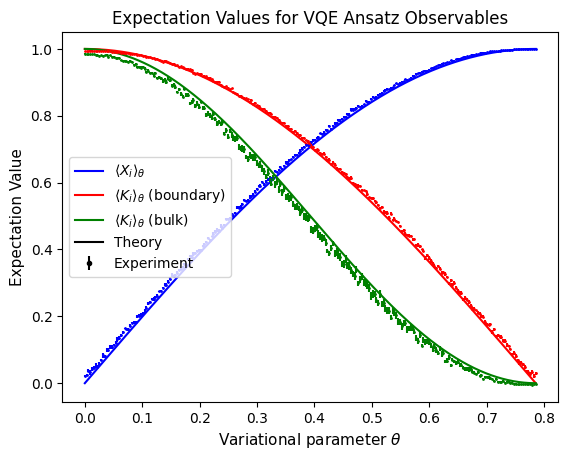

In [5]:
plt.plot(theta_ar_smooth, X(theta_ar_smooth), "b-", label=r"$\langle X_i \rangle_\theta$")
plt.errorbar(theta_ar, X_ar_mean, yerr=X_ar_std, fmt='.', color='b', markersize=2)
plt.plot(theta_ar_smooth, Kbound(theta_ar_smooth), "r-", label=r"$\langle K_i \rangle_\theta$ (boundary)")
plt.errorbar(theta_ar, K_boundary_ar_mean, yerr= K_boundary_ar_std, fmt='.', color='r', markersize=2)
plt.plot(theta_ar_smooth, Kbulk(theta_ar_smooth), "g-", label=r"$\langle K_i \rangle_\theta$ (bulk)")
plt.errorbar(theta_ar, K_bulk_ar_mean, yerr=K_bulk_ar_std,  fmt='.', color='g', markersize=2)
plt.plot([], [], "k-", label="Theory")
plt.errorbar([], [], yerr=[], fmt="k.", label="Experiment")
plt.title("Expectation Values for VQE Ansatz Observables", size=12)
plt.ylabel("Expectation Value", size=11)
plt.xlabel(r"Variational parameter $\theta$", size=11)
plt.legend(loc=6, fontsize=10)
plt.savefig("figures/VQE_expectations.pdf")

In [5]:
def E(alpha, N, X_ar_mean, K_boundary_ar_mean, K_bulk_ar_mean):
    """
    Give the energy expectation as a function of alpha (intepolation parameter), N (length of chain)
    """
    product = -np.sin(alpha)*(N - 2)*np.array(X_ar_mean)
    cluster = -np.cos(alpha)*(4*np.array(K_boundary_ar_mean) + (N - 4)*np.array(K_bulk_ar_mean))
    return product + cluster

def E_err(alpha, N, X_ar_std, K_boundary_ar_std, K_bulk_ar_std):
    """
    """
    product_err = -np.sin(alpha)*(N - 2)*np.array(X_ar_std)
    cluster_err = -np.cos(alpha)*(np.sqrt((4*np.array(K_boundary_ar_std))**2 + ((N - 4)*np.array(K_bulk_ar_std))**2))
    return np.sqrt(product_err**2 + cluster_err**2)

def E_ideal(alpha, N):
    """
    Give the energy expectation as a function of alpha (intepolation parameter), N (length of chain)
    """
    product = -np.sin(alpha)*(N - 2)*X(theta_ar_smooth)
    cluster = -np.cos(alpha)*(4*Kbound(theta_ar_smooth) + (N - 4)*Kbulk(theta_ar_smooth))
    return product + cluster

def thetamin_and_error_estimate(alpha, N, theta_ar, X_ar_mean, K_boundary_ar_mean, K_bulk_ar_mean, X_ar_std, K_boundary_ar_std, K_bulk_ar_std):
    E_ar = E(alpha, N, X_ar_mean, K_boundary_ar_mean, K_bulk_ar_mean)
    E_err_ar = E_err(alpha, N, X_ar_std, K_boundary_ar_std, K_bulk_ar_std)
    Emin = np.min(E_ar)
    thetamin = theta_ar[np.argmin(E_ar)]
    diff_ar = E_ar - E_err_ar
    indices_below_Emin = []
    for i in range(len(theta_ar)):
        if diff_ar[i] < Emin:
            indices_below_Emin.append(i)
    theta_err = (theta_ar[indices_below_Emin[-1]] - theta_ar[indices_below_Emin[0]])/2
    return thetamin, theta_err

In [26]:
alphas_smooth=np.linspace(0, np.pi/2, 1000)
alphas =np.linspace(0, np.pi/2, 50)
alphas_1 = np.linspace(0, np.arctan(2), 40000)
alphas_2 = np.linspace(np.arctan(2), np.pi/2, 6000)

In [27]:
thetamins_9 = []
thetamins_9_err = []
thetamins_ideal_9 = []
thetamins_5 = []
thetamins_5_err = []
thetamins_ideal_5 = []
for alpha in alphas:
    thetamin, theta_err = thetamin_and_error_estimate(alpha, 9, theta_ar, X_ar_mean, K_boundary_ar_mean, K_bulk_ar_mean, X_ar_std, K_boundary_ar_std, K_bulk_ar_std)
    thetamins_9.append(thetamin)
    thetamins_9_err.append(theta_err)
    thetamin, theta_err = thetamin_and_error_estimate(alpha, 5, theta_ar, X_ar_mean, K_boundary_ar_mean, K_bulk_ar_mean, X_ar_std, K_boundary_ar_std, K_bulk_ar_std)
    thetamins_5.append(thetamin)
    thetamins_5_err.append(theta_err)
for alpha in alphas_smooth:
    thetamins_ideal_9.append(theta_ar_smooth[np.argmin(E_ideal(alpha, 9))])
    thetamins_ideal_5.append(theta_ar_smooth[np.argmin(E_ideal(alpha, 5))])

/var/folders/j1/1hxsj1cs7jl3mgs2v23v3wx00000gn/T/ipykernel_7743/942225913.py:1: RuntimeWarning: invalid value encountered in arcsin
  plt.plot(alphas_1, 0.5*np.arcsin(np.tan(alphas_1)/2), "b-", label=r"Theory, $N=\infty$")


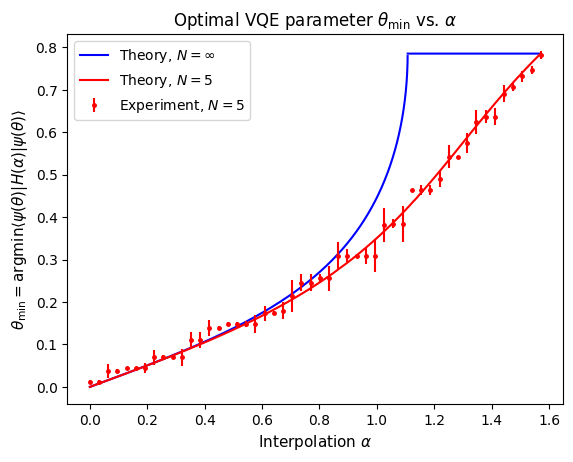

In [28]:
plt.plot(alphas_1, 0.5*np.arcsin(np.tan(alphas_1)/2), "b-", label=r"Theory, $N=\infty$")
plt.plot(alphas_2, np.pi/4*np.ones(len(alphas_2)), "b-")
# plt.plot(alphas_smooth, thetamins_ideal_9, "r-",label=r"Theory, $N=9$")
# plt.errorbar(alphas, thetamins_9, yerr=thetamins_9_err, fmt='.', color='r', label=r"Experiment, $N=9$", markersize=5)
plt.plot(alphas_smooth, thetamins_ideal_5, "r-",label=r"Theory, $N=5$")
plt.errorbar(alphas, thetamins_5, yerr=thetamins_5_err, fmt='.', color='r', label=r"Experiment, $N=5$", markersize=5)
plt.legend(fontsize=10, loc="best")
plt.title(r"Optimal VQE parameter $\theta_{\text{min}}$ vs. $\alpha$", size=12)
plt.xlabel(r"Interpolation $\alpha$", size=11)
plt.ylabel(r"$\theta_{\text{min}} = \text{argmin}\langle \psi(\theta) \vert H(\alpha) \vert \psi(\theta) \rangle$", size=11)
plt.savefig("figures/VQE_variationalparameter.pdf")
plt.show()

In [9]:
alphas_exp = np.linspace(0, np.pi/2, 9)
thetamins_5_exp = []
thetamins_5_exp_err = []

for alpha in alphas_exp:
    thetamin, theta_err = thetamin_and_error_estimate(alpha, 5, theta_ar, X_ar_mean, K_boundary_ar_mean, K_bulk_ar_mean, X_ar_std, K_boundary_ar_std, K_bulk_ar_std)
    thetamins_5_exp.append(thetamin)
    thetamins_5_exp_err.append(theta_err)

In [10]:
def SOP_and_error_estimate(alpha, N, X_ar_mean, K_boundary_ar_mean, K_bulk_ar_mean, K_boundary_ar_std):
    E_ar = E(alpha, N, X_ar_mean, K_boundary_ar_mean, K_bulk_ar_mean)
    E_err_ar = E_err(alpha, N, X_ar_std, K_boundary_ar_std, K_bulk_ar_std)
    Emin = np.min(E_ar)
    diff_ar = E_ar - E_err_ar
    indices_below_Emin = []
    for i in range(len(theta_ar)):
        if diff_ar[i] < Emin:
            indices_below_Emin.append(i)
    SOP_val = K_boundary_ar_mean[np.argmin(E_ar)]

    SOP_val_max = K_boundary_ar_mean[indices_below_Emin[-1]]
    SOP_val_min = K_boundary_ar_mean[indices_below_Emin[0]]

    SOP_err_minimization = (SOP_val_max - SOP_val_min) / 2
    SOP_err_statistical = K_boundary_ar_std[np.argmin(E_ar)]
    return SOP_val, np.sqrt(SOP_err_minimization**2 + SOP_err_statistical**2)

def ideal_SOP(alpha, N):
    thetamin = theta_ar_smooth[np.argmin(E_ideal(alpha, N))]
    return Kbound(thetamin)

In [11]:
SOP_vals_exp = []
SOP_vals_exp_err = []
SOP_vals_ideal = []
for alpha in alphas_exp:
    SOP_val, SOP_err = SOP_and_error_estimate(alpha, 5, X_ar_mean, K_boundary_ar_mean, K_bulk_ar_mean, K_boundary_ar_std)
    SOP_vals_exp.append(SOP_val)
    SOP_vals_exp_err.append(SOP_err)
    SOP_vals_ideal.append(ideal_SOP(alpha, 5))

In [12]:
SOP_vals_ideal = []
for alpha in alphas_smooth:
    SOP_vals_ideal.append(ideal_SOP(alpha, 5))

In [13]:
# Thetas, SOPs for COP=SOP experiments
np.savez('processed_data/VQE_N5_thetamins_and_SOPs.npz', alphas_exp=alphas_exp, thetamins_5_exp=thetamins_5_exp, thetamins_5_exp_err=thetamins_5_exp_err, SOP_vals_exp=SOP_vals_exp, SOP_vals_exp_err=SOP_vals_exp_err, alphas_smooth=alphas_smooth, SOP_vals_ideal=SOP_vals_ideal)

In [14]:
# Theta for divide-and-conquer experiments
alpha = np.pi/3
thetamin, theta_err = thetamin_and_error_estimate(alpha, 9, theta_ar, X_ar_mean, K_boundary_ar_mean, K_bulk_ar_mean, X_ar_std, K_boundary_ar_std, K_bulk_ar_std)
SOP_val, SOP_err = SOP_and_error_estimate(alpha, 9, X_ar_mean, K_boundary_ar_mean, K_bulk_ar_mean, K_boundary_ar_std)
SOP_val_ideal = ideal_SOP(alpha, 9)

In [15]:
np.savez('processed_data/VQE_N9_thetamin_and_SOP.npz', alpha=np.array([alpha]), thetamin_9_exp=np.array([thetamin]), theta_9_exp_err=np.array([theta_err]), SOP_val_exp=np.array([SOP_val]), SOP_val_exp_err=np.array([SOP_err]), SOP_val_ideal=np.array([SOP_val_ideal]))